In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
import math
from scipy.optimize import curve_fit
from collections import deque, defaultdict
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Dataframe defining functions

In [2]:
def connectivityExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    connectivity_raw = data_structure['connectivity'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    connectivity_data = connectivity_raw.squeeze()
    # Create a DataFrame from the connectivity data
    connectivity_df = pd.DataFrame(connectivity_data, columns=['Parent', 'Daughter1', 'Daughter2', 'Daughter3'])
    connectivity_df.replace(0, np.nan, inplace=True) #ensure all nonexistent vessels have NaN
    connectivity_df.at[0,'Parent']=0 #make sure first vessel is 0 (purposefully removed in last step for ease)
    # Save the DataFrame to inspect it
    return connectivity_df

def lengthExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'lengths' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    length_raw = data_structure['lengths'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    length_data = length_raw.squeeze()
    # Create a DataFrame from the data
    length_df = pd.DataFrame(length_data, columns=['Length'])
    # Save the DataFrame to inspect it
    return length_df

def radiusExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'radius' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    radius_raw = data_structure['rin'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    radius_data = radius_raw.squeeze()
    # Create a DataFrame from the data
    radius_df = pd.DataFrame(radius_data, columns=['Radius'])
    # Save the DataFrame to inspect it
    return radius_df

def volumeExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name + '.mat'
    matlab_data = scipy.io.loadmat(file_path)
    volume_raw = matlab_data['volumes']  # This is an x by 1 or 1D array
    volume_data = volume_raw.squeeze()  # Converts to 1D array if it's still 2D with 1 column
    volume_df = pd.DataFrame(volume_data, columns=['Volume'])
    return volume_df

def lRR(data):
    lrr = np.empty((0,0))
    for i in np.arange(data.shape[0]): #iterate over every vessel
        length = data.iloc[i]['Length'] #pull the length value
        radius = data.iloc[i]['Radius'] #retreive radius value
        lrr_value = length/radius #calculate lrr
        lrr = np.append(lrr,lrr_value) #append lrr value to total list
    data['Length/Radius'] = lrr.tolist() #add list to table
    return data

def assignDepth(data):
    tree = {} 
    for _, row in data.iterrows(): #iterate over every row
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist() #only select daughter values that exist
        tree[parent] = daughters
    # Step 2: BFS traversal to assign depths
    depths = {}
    queue = deque([(data['Parent'].iloc[0], 0)])  # Start from root (first parent)

    while queue:
        node, depth = queue.popleft()
        depths[node] = depth
        for child in tree.get(node, []):
            if child not in depths:  # Avoid revisiting
                queue.append((child, depth + 1))
    data['Depth'] = data['Parent'].map(depths)
    return data

def lengthFromRoot(data):
    tree = {}
    length_dict = dict(zip(data['Parent'], data['Length']))  # Map each vessel (parent) to its length

    for _, row in data.iterrows():
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist()
        tree[parent] = daughters

    # BFS traversal to calculate cumulative lengths
    lengths = {}
    root = data['Parent'].iloc[0]
    queue = deque([(root, 0)])  # Start with cumulative length 0

    while queue:
        node, cum_length = queue.popleft()
        lengths[node] = cum_length
        for child in tree.get(node, []):
            if child not in lengths:  # Avoid revisiting
                additional_length = length_dict.get(child, 0)
                queue.append((child, cum_length + additional_length))

    data['LengthFromRoot'] = data['Parent'].map(lengths)
    return data

def nodesExtractor(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'nodes' field
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractor(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'segments' field
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def mapIDExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'mapID' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    map_raw = data_structure['mapIDs'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    map_data = map_raw.squeeze()
    # Create a DataFrame from the connectivity data
    map_df = pd.DataFrame(map_data, columns=['New', 'Old'])
    # Save the DataFrame to inspect it
    return map_df

def tortuosityCalculator(data,name):
    nodes = nodesExtractor(name)
    edges = edgesExtractor(name)
    maps = mapIDExtractor(name)
    tortuosity = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        old_vesID = maps.iloc[i]['Old'] #find the old vessel ID
        edge_row = edges.index.get_loc(edges[edges['ID'] == old_vesID].index[0])
        node1 = edges.iloc[edge_row]['From'] #identify from node
        node2 = edges.iloc[edge_row]['To'] #identify to node
        node1_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node1].index[0])
        node2_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node2].index[0])
        node1_x = nodes.iloc[node1_row]['X'] #pull node 3d coordinate
        node1_y = nodes.iloc[node1_row]['Y']
        node1_z = nodes.iloc[node1_row]['Z']
        node2_x = nodes.iloc[node2_row]['X']
        node2_y = nodes.iloc[node2_row]['Y']
        node2_z = nodes.iloc[node2_row]['Z']
        euclid_dist = math.sqrt((node1_x - node2_x)**2 + (node1_y - node2_y)**2 + (node1_z - node2_z)**2) #calculate euclidean distance between from and to
        length = data.iloc[i]['Length'] #pull length and convert to mm
        ratio = length/euclid_dist #find tortuosity ratio
        tortuosity = np.append(tortuosity,ratio)
    data['Tortuosity'] = tortuosity.tolist() #add to table
    return data

def radiusFinder(data):
    dv1r = np.empty((0,0))
    dv2r = np.empty((0,0))
    dv3r = np.empty((0,0))
    for i in np.arange(data.shape[0]):# iterate over every row
        dv1 = data.iloc[i]['Daughter1'] #pull radii values
        dv2 = data.iloc[i]['Daughter2']
        dv3 = data.iloc[i]['Daughter3']
        if math.isnan(dv1): #if daughter vessel 1 doesn't exist, none of them do
            dv1r = np.append(dv1r,np.nan)
            dv2r = np.append(dv2r,np.nan)
            dv3r = np.append(dv3r,np.nan)
            continue
        dv1r = np.append(dv1r,data.iloc[int(dv1)][2])
        dv2r = np.append(dv2r,data.iloc[int(dv2)][2])
        if math.isnan(dv3): #explicitly check whetehr dv3 exist
            dv3r = np.append(dv3r,np.nan)
            continue
        dv3r = np.append(dv3r,data.iloc[int(dv3)][2])
    data['DV1R'] = dv1r.tolist()
    data['DV2R'] = dv2r.tolist()
    data['DV3R'] = dv3r.tolist()
    #select and reorder columns
    data = data.loc[:,['Parent','Depth','Length','Radius','Volume', 'Length/Radius','LengthFromRoot','Tortuosity','Daughter1','DV1R','Daughter2','DV2R','Daughter3','DV3R']]
    return data

def alphaBeta(data):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #check if trifurcation, if it is then don't calculate
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R']
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #check if daughter vessels exist
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        if dv1r>=dv2r: #case 1 of daughter vessels
            alpha_value = dv1r/pv
            beta_value = dv2r/pv
        else: #case 2 of daughter vessels
            alpha_value = dv2r/pv
            beta_value = dv1r/pv
        alpha = np.append(alpha,alpha_value)
        beta = np.append(beta,beta_value)
    data['Alpha'] = alpha.tolist() #add alpha and beta to total table
    data['Beta'] = beta.tolist()
    return data

def xiFinder(data):
    xi_values = np.empty((0,0))
    error_values = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        rp = data.iloc[i]['Radius'] #pull all radii
        rd1 = data.iloc[i]['DV1R']
        rd2 = data.iloc[i]['DV2R']
        rd3 = data.iloc[i]['DV3R']
        if not math.isnan(rd3): #don't calculate if trifucation
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        if math.isnan(rd1): #don't calculate if no daughter vessels
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        while abs(error) > 1e-4: #allow for error up to 10^-4
            fun = rp**xi - rd1**xi - rd2**xi # solve at f(xi)
            fun2 = (rp**xi)*math.log(rp) - (rd1**xi)*math.log(rd1) - (rd2**xi)*math.log(rd2) #solve at f'(xi)
            xi = xi - fun/fun2 # new xi value
            error = rp**xi - rd1**xi - rd2**xi #calculate new error
        if xi > 6: #bound xi
            xi = 6
        if xi < 1:
            xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        xi_values = np.append(xi_values,xi)
        error_values = np.append(error_values,error)
    data['Xi'] = xi_values.tolist()#add xi to the table
    #data['Error Newton'] = error_values.tolist()
    return data

def asymmetry(data):
    asym = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #don't calculate if trifucation
            asym = np.append(asym,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull radii
        dv2r = data.iloc[i]['DV2R']
        if math.isnan(dv1r): #if no daughters, skip
            asym = np.append(asym,np.nan)
            continue
        if dv1r>=dv2r: #case 1
            asym_value = (dv2r/dv1r)**2
        else: #case 2
            asym_value = (dv1r/dv2r)**2
        asym = np.append(asym,asym_value)
    data['Gamma'] = asym.tolist() #add to table
    return data

def area(data):
    area = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #if trifucation, skip
            area = np.append(area,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull necessary radii
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #if no daughters, skip
            area = np.append(area,np.nan)
            continue
        area_value = (dv1r**2+dv2r**2)/(pv**2) #calculate eta
        area = np.append(area,area_value)
    data['Eta'] = area.tolist() #add to table
    return data

def dataExtractor(name): #sequentially calls necessary functions to create full table
    connectivity = connectivityExtractor(name)
    length = lengthExtractor(name)
    radius = radiusExtractor(name)
    volume = volumeExtractor(name)
    combined = pd.concat([connectivity.iloc[:, :1], length, radius, volume, connectivity.iloc[:, 1:]], axis=1)
    lengthradius = lRR(combined)
    #print('LRR')
    depthness = assignDepth(lengthradius)
    #print('Depth')
    lengthTotal = lengthFromRoot(depthness)
    #print('LengthFromRoot')
    tortuos = tortuosityCalculator(lengthTotal,name)
    #print('Tortousity')
    allradii = radiusFinder(tortuos)
    alphabetazed = alphaBeta(allradii)
    #print('Alpha/beta')
    xi = xiFinder(alphabetazed)
    #print('Xi')
    asymmetric = asymmetry(xi)
    #print('Gamma')
    areated = area(asymmetric)
    return areated

def saveStatistics(name): #saves the stats as .csv for exporting
    statistics = dataExtractor(name)[["Parent", "Depth",'Length','Radius','Volume','Length/Radius','LengthFromRoot','Tortuosity','Alpha','Beta','Xi','Gamma','Eta']] #selects correct columns
    file_path = 'Statistics/Statistics_' + name +'.csv'
    statistics.to_csv(file_path) #shouldn't return anything, just save

def leaveDetails(name):
    statistics = dataExtractor(name)
    dropped = statistics.dropna(subset='DV1R')
    internal = dropped.shape[0]
    tris = dropped['DV3R'].count()
    leaves = statistics['DV1R'].isna().sum()
    triratio = tris/internal * 100
    avgdepth = statistics['Depth'].mean()
    stddepth = statistics['Depth'].std()
    print(name)
    print('# of vessels: ' + str(statistics.shape[0]))
    print('# of leaves (terminal vessels): ' + str(leaves))
    print('# of internal vessels: ' + str(internal))
    print('# of trifurcations: '+ str(tris))
    print('% of trifurcations: ' + str(round(triratio,3)))
    print('Average Depth: ' + str(round(avgdepth,3)))
    print('St. Dev. Depth: ' + str(round(stddepth,3)))

In [23]:
control3p4 = dataExtractor('m3p4_060407')
control1p4 = dataExtractor('m1p4_060407')
control2p4 = dataExtractor('m2p4_060407')
hyper1p4 = dataExtractor('m1p4_053007')
hyper2p4 = dataExtractor('m2p4_053007')
hyper3p4 = dataExtractor('m1p4_053107')
control3p1 = dataExtractor('m3p1_060407')
control1p1 = dataExtractor('m1p1_060407')
control2p1 = dataExtractor('m2p1_060407')
hyper1p1 = dataExtractor('m1p1_053007')
hyper2p1 = dataExtractor('m2p1_053007')
hyper3p1 = dataExtractor('m1p1_053107')

In [6]:
ex = dataExtractor('m1p4_060407')
ex.head(10)

,Parent,Depth,Length,Radius,Volume,Length/Radius,LengthFromRoot,Tortuosity,Daughter1,DV1R,Daughter2,DV2R,Daughter3,DV3R,Alpha,Beta,Xi,Gamma,Eta
0,0.0,0,4186.102550,455.226872,2.793036e+09,9.195640,0.000000,1.312250,506.0,395.47905,553.0,270.178169,NaN,NaN,0.868752,0.593502,1.0,0.466717,1.106974
1,1.0,8,442.372419,79.007783,8.304625e+06,5.599099,13363.236275,1.127026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,3,1994.113824,72.447712,9.619764e+07,27.524869,10196.737444,1.148733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,6,1758.520305,89.168530,6.545334e+07,19.721311,14790.527065,1.271064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,9,2477.737252,102.829980,8.555389e+07,24.095475,12509.855376,1.220601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5.0,5,2548.537718,74.976955,8.150833e+07,33.990947,11916.556061,1.346928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6.0,14,423.755084,67.906405,6.305599e+06,6.240281,16428.191128,1.345226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7.0,16,691.658364,69.973291,1.473450e+07,9.884605,15291.309824,1.124035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8.0,17,790.017413,59.070137,1.395414e+07,13.374227,21773.010735,1.229929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9.0,12,305.311682,60.140555,3.445837e+06,5.076636,15563.183178,1.109472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
dataExtractor('m2p1_060407')['Volume'].sum()/(1000**3)

np.float64(100.80106043721567)

In [ ]:
"""m3p4c = 'm3p4_060407'
control3p4 = dataExtractor(m3p4c)
m2p4c = 'm2p4_060407'
control2p4 = dataExtractor(m2p4c)
m1p4c = 'm1p4_060407'
control1p4 = dataExtractor(m1p4c)
m1p4h = 'm1p4_053007'
hyper1p4 = dataExtractor(m1p4h)
m2p4h = 'm2p4_053007'
hyper2p4 = dataExtractor(m2p4h)
m3p4h = 'm1p4_053107'
hyper3p4 = dataExtractor(m3p4h)"""

In [5]:
leaveDetails('m1p1_060407')
leaveDetails('m2p1_060407')
leaveDetails('m3p1_060407')
leaveDetails('m1p1_053007')
leaveDetails('m2p1_053007')
leaveDetails('m1p1_053107')

m1p1_060407
# of vessels: 1589
# of leaves (terminal vessels): 826
# of internal vessels: 763
# of trifurcations: 62
% of trifurcations: 8.126
Average Depth: 14.937
St. Dev. Depth: 5.138
m2p1_060407
# of vessels: 2995
# of leaves (terminal vessels): 1567
# of internal vessels: 1428
# of trifurcations: 138
% of trifurcations: 9.664
Average Depth: 19.63
St. Dev. Depth: 6.723
m3p1_060407
# of vessels: 2590
# of leaves (terminal vessels): 1358
# of internal vessels: 1232
# of trifurcations: 125
% of trifurcations: 10.146
Average Depth: 15.424
St. Dev. Depth: 5.249
m1p1_053007
# of vessels: 2624
# of leaves (terminal vessels): 1369
# of internal vessels: 1255
# of trifurcations: 113
% of trifurcations: 9.004
Average Depth: 17.225
St. Dev. Depth: 6.053
m2p1_053007
# of vessels: 1911
# of leaves (terminal vessels): 999
# of internal vessels: 912
# of trifurcations: 86
% of trifurcations: 9.43
Average Depth: 15.77
St. Dev. Depth: 5.344
m1p1_053107
# of vessels: 3296
# of leaves (terminal vesse

In [ ]:
leaveDetails('m3p1_060407')
leaveDetails('m1p1_053007')

In [ ]:
saveStatistics('m3p4_060407')

# Bin Graphs

In [ ]:
def bintoplotAB(data):
    filtered = data[data['Radius'] < .4*data.iloc[0][2]]
    filtered = filtered.drop('DV3R',axis=1)
    filtered = filtered.dropna()
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
    a = filtered.groupby('binned')['Radius'].mean()
    b = filtered.groupby('binned')['Alpha'].mean()
    c = filtered.groupby('binned')['Beta'].mean()
    return a,b,c


In [ ]:
"""c3p4r,c3p4a,c3p4b = bintoplotAB(control3p4)
c2p4r,c2p4a,c2p4b = bintoplotAB(control2p4)
c1p4r,c1p4a,c1p4b = bintoplotAB(control1p4)
h1p4r,h1p4a,h1p4b = bintoplotAB(hyper1p4)
h2p4r,h2p4a,h2p4b = bintoplotAB(hyper2p4)
h3p4r,h3p4a,h3p4b = bintoplotAB(hyper3p4)

controla = np.concatenate((c1p4a,c2p4a,c3p4a),axis=0)
controlr = np.concatenate((c1p4r,c2p4r,c3p4r),axis=0)
controlb = np.concatenate((c1p4b,c2p4b,c3p4b),axis=0)
hypa = np.concatenate((h1p4a,h2p4a,h3p4a),axis=0)
hypb = np.concatenate((h1p4b,h2p4b,h3p4b),axis=0)
hypr = np.concatenate((h1p4r,h2p4r,h3p4r),axis=0)

def exponential(x, a, b):
    return a * np.exp(b * x)

paramsca, _ = curve_fit(exponential, controlr, controla)
paramscb, _ = curve_fit(exponential, controlr, controlb)
paramsha, _ = curve_fit(exponential, hypr, hypa)
paramshb, _ = curve_fit(exponential, hypr, hypb)

x_range = np.linspace(.15,.3, 100)

ca_fit = exponential(x_range, *paramsca)
cb_fit = exponential(x_range, *paramscb)
ha_fit = exponential(x_range, *paramsha)
hb_fit = exponential(x_range, *paramshb)

plt.scatter(c3p4r,c3p4a, c='b', marker='x', label='Alpha C3')
plt.scatter(c3p4r, c3p4b, c='r', marker='x', label='Beta C3')
plt.scatter(c2p4r,c2p4a, c='b', marker='^', label='Alpha C2')
plt.scatter(c2p4r, c2p4b, c='r', marker='^', label='Beta C2')
plt.scatter(c1p4r,c1p4a, c='b', marker='s', label='Alpha C1')
plt.scatter(c1p4r, c1p4b, c='r', marker='s', label='Beta C1')
plt.scatter(h1p4r,h1p4a, c='g', marker='.', label='Alpha H1')
plt.scatter(h1p4r, h1p4b, c='m', marker='.', label='Beta H1')
plt.scatter(h2p4r,h2p4a, c='g', marker='*', label='Alpha H2')
plt.scatter(h2p4r, h2p4b, c='m', marker='*', label='Beta H2')
plt.scatter(h3p4r,h3p4a, c='g', marker='D', label='Alpha H3')
plt.scatter(h3p4r, h3p4b, c='m', marker='D', label='Beta H3')
plt.plot(x_range, ca_fit, color='red', linestyle='-', label='Control Alpha')
plt.plot(x_range, cb_fit, color='red', linestyle='--', label='Control Beta')
plt.plot(x_range, ha_fit, color='green', linestyle='-', label='Hypertensive Alpha')
plt.plot(x_range, hb_fit, color='green', linestyle='--', label='Hypertensive Beta')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlim(.15, .3)
plt.ylim(.3, 1.2)
plt.show()"""

In [ ]:
def boxtoplotLRR(data):
    filtered = data[data['Radius'] < .4*data.iloc[0][2]]
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
    a = filtered.groupby('binned')['Length/Radius'].mean()
    b = filtered.groupby('binned')['Radius'].mean()
    return a,b

In [ ]:
"""c3p4lrr,c3p4r = boxtoplotLRR(control3p4)
c2p4lrr,c2p4r = boxtoplotLRR(control2p4)
c1p4lrr,c1p4r = boxtoplotLRR(control1p4)
h3p4lrr,h3p4r = boxtoplotLRR(hyper3p4)
h2p4lrr,h2p4r = boxtoplotLRR(hyper2p4)
h1p4lrr,h1p4r = boxtoplotLRR(hyper1p4)

controllrr = np.concatenate((c1p4lrr,c2p4lrr,c3p4lrr),axis=0)
controlr = np.concatenate((c1p4r,c2p4r,c3p4r),axis=0)
hyplrr = np.concatenate((h1p4lrr,h2p4lrr,h3p4lrr),axis=0)
hypr = np.concatenate((h1p4r,h2p4r,h3p4r),axis=0)

def exponential(x, a, b):
    return a * np.exp(-b * x)

paramsclrr, _ = curve_fit(exponential, controlr, controllrr)
paramshlrr, _ = curve_fit(exponential, hypr, hyplrr)

x_range = np.linspace(.1,.4, 100)

clrr_fit = exponential(x_range, *paramsclrr)
hlrr_fit = exponential(x_range, *paramshlrr)

plt.scatter(c3p4r,c3p4lrr, c='b', marker='x', label='C3')
plt.scatter(c2p4r,c2p4lrr, c='b', marker='.', label='C2')
plt.scatter(c1p4r,c1p4lrr, c='b', marker='*', label='C1')
plt.scatter(h3p4r,h3p4lrr, c='c', marker='x', label='H3')
plt.scatter(h2p4r,h2p4lrr, c='c', marker='.', label='H2')
plt.scatter(h1p4r,h1p4lrr, c='c', marker='*', label='H1')
plt.plot(x_range, clrr_fit, color='red', linestyle='--', label='Control LRR Fit')
plt.plot(x_range, hlrr_fit, color='green', linestyle='-', label='Hypertensive LRR Fit')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel('Radius (cm)')
plt.ylabel('Length to Radius Ratio')
plt.show()"""

In [ ]:
fc3p4 = control3p4[control3p4['Alpha'] > 1]
fc3p4a = fc3p4['Alpha']
fc3p4r = fc3p4['Radius']
plt.scatter(fc3p4r,fc3p4a, c='b', marker='x', label='Alpha')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

In [ ]:
filtered = control3p4[control3p4['Radius'] < .4*control3p4.iloc[0][2]]
filtered = filtered[['Radius', 'Xi']]
filtered = filtered.dropna()
labels = np.arange(20)
filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
a = filtered.groupby('binned')['Xi'].mean()
b = filtered.groupby('binned')['Radius'].mean()
plt.scatter(b,a, c='b', marker='x', label='C3')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel('Radius (cm)')
plt.ylabel('Xi')
plt.show()

In [ ]:
a = control3p4['LengthFromRoot']
b = control3p4['Radius']
terms = control3p4[control3p4['DV1R'].isna()]
d = terms['LengthFromRoot']
c = terms['Radius']
plt.scatter(a,b, c='b', marker='x', label='C3 int')
plt.scatter(d,c,c='r',marker = 'x', label = 'C3 term')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.ylabel('Radius (cm)')
plt.xlabel('Distance from Root (cm)')
plt.show()

In [ ]:
a = control3p4['LengthFromRoot']
b = control3p4['Volume']
terms = control3p4[control3p4['DV1R'].isna()]
d = terms['LengthFromRoot']
c = terms['Volume']
plt.scatter(a,b, c='b', marker='x', label='C3 int')
plt.scatter(d,c,c='r',marker = 'x', label = 'C3 term')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.ylabel('Length (cm)')
plt.xlabel('LengthFromRoot (cm)')
plt.show()

In [ ]:
#a = control3p4['LengthFromRoot']
#b = control3p4['Volume']
internals = control3p4.dropna(subset='DV1R')
a = 'Length'
b = 'LengthFromRoot'
d = internals[a]
c = internals[b]
#plt.scatter(a,b, c='b', marker='x', label='C3 int')
plt.scatter(d,c,c='b',marker = 'x', label = 'C3 internals')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.ylabel(b)
plt.xlabel(a)
plt.show()

# Volume Idea Pressure 4

In [25]:
print('Control 1: ' + str(int(control1p4['Volume'].sum())/(1000**3)))
print('Control 2: ' + str(int(control2p4['Volume'].sum())/(1000**3)))
print('Control 3: ' + str(int(control3p4['Volume'].sum())/(1000**3)))
print('Hyper 1: ' + str(int(hyper1p4['Volume'].sum())/(1000**3)))
print('Hyper 2: ' + str(int(hyper2p4['Volume'].sum())/(1000**3)))
print('Hyper 3: ' + str(int(hyper3p4['Volume'].sum())/(1000**3)))
#print('Hyper trimmed: ' + str(int(hyper1p4[hyper1p4['Depth']<=26]['Volume'].sum())/(1000**3)))
#print('Difference: ' + str((int(hyper1p4['Volume'].sum())-int(control3p4['Volume'].sum()))/(1000**3)))
#print('Hyper percent increase: ' + str((int(hyper1p4['Volume'].sum())-int(control3p4['Volume'].sum()))/int(control3p4['Volume'].sum())*100))

Control 1: 48.801518452
Control 2: 38.74399068
Control 3: 75.584150924
Hyper 1: 80.078252723
Hyper 2: 100.632498619
Hyper 3: 85.315054993


In [34]:
c1p4vs = control1p4.groupby('Depth')['Volume'].sum()/(1000**3)
c1p4d = control1p4.groupby('Depth')['Depth'].count()
c1p4va = control1p4.groupby('Depth')['Volume'].mean()/(1000**3)
c1p4p = np.arange(0, len(c1p4d))
c2p4vs = control2p4.groupby('Depth')['Volume'].sum()/(1000**3)
c2p4d = control2p4.groupby('Depth')['Depth'].count()
c2p4va = control2p4.groupby('Depth')['Volume'].mean()/(1000**3)
c2p4p = np.arange(0, len(c2p4d))
c3p4vs = control3p4.groupby('Depth')['Volume'].sum()/(1000**3)
c3p4d = control3p4.groupby('Depth')['Depth'].count()
c3p4va = control3p4.groupby('Depth')['Volume'].mean()/(1000**3)
c3p4p = np.arange(0, len(c3p4d))
h1p4vs = hyper1p4.groupby('Depth')['Volume'].sum()/(1000**3)
h1p4d = hyper1p4.groupby('Depth')['Depth'].count()
h1p4va = hyper1p4.groupby('Depth')['Volume'].mean()/(1000**3)
h1p4p=np.arange(0,len(h1p4d))
h2p4vs = hyper2p4.groupby('Depth')['Volume'].sum()/(1000**3)
h2p4d = hyper2p4.groupby('Depth')['Depth'].count()
h2p4va = hyper2p4.groupby('Depth')['Volume'].mean()/(1000**3)
h2p4p=np.arange(0,len(h2p4d))
h3p4vs = hyper3p4.groupby('Depth')['Volume'].sum()/(1000**3)
h3p4d = hyper3p4.groupby('Depth')['Depth'].count()
h3p4va = hyper3p4.groupby('Depth')['Volume'].mean()/(1000**3)
h3p4p=np.arange(0,len(h3p4d))

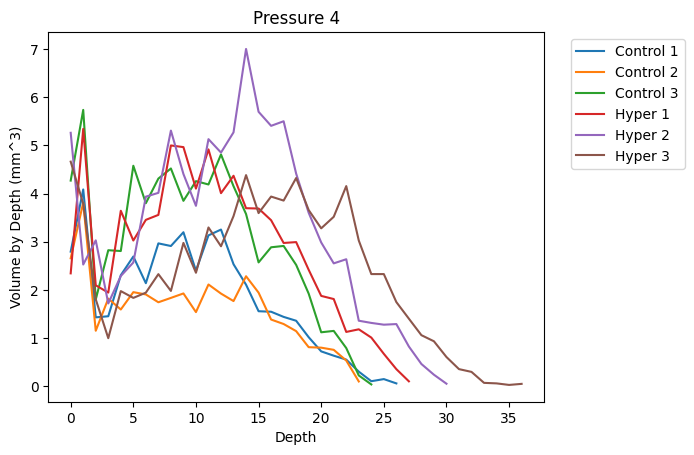

In [29]:
plt.plot(c1p4p,c1p4vs,label='Control 1')
plt.plot(c2p4p,c2p4vs,label='Control 2')
plt.plot(c3p4p,c3p4vs,label='Control 3')
plt.plot(h1p4p,h1p4vs,label='Hyper 1')
plt.plot(h2p4p,h2p4vs,label='Hyper 2')
plt.plot(h3p4p,h3p4vs,label='Hyper 3')
plt.ylabel('Volume by Depth (mm^3)')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.title('Pressure 4')
plt.show()

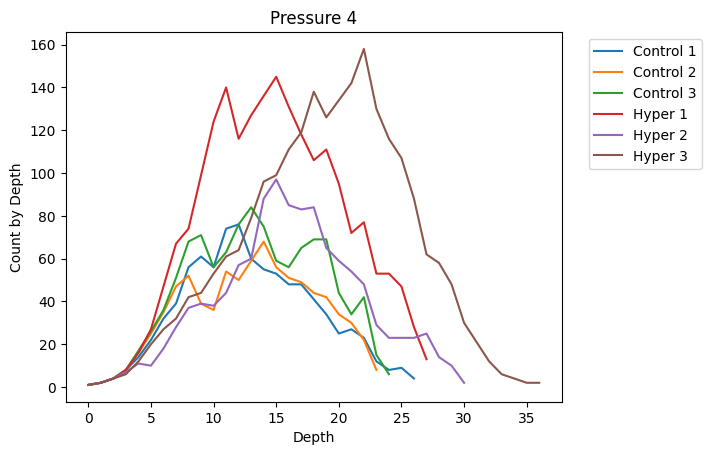

In [30]:
plt.plot(c1p4p,c1p4d,label='Control 1')
plt.plot(c2p4p,c2p4d,label='Control 2')
plt.plot(c3p4p,c3p4d,label='Control 3')
plt.plot(h1p4p,h1p4d,label='Hyper 1')
plt.plot(h2p4p,h2p4d,label='Hyper 2')
plt.plot(h3p4p,h3p4d,label='Hyper 3')
plt.ylabel('Count by Depth')
plt.xlabel('Depth')
plt.title('Pressure 4')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

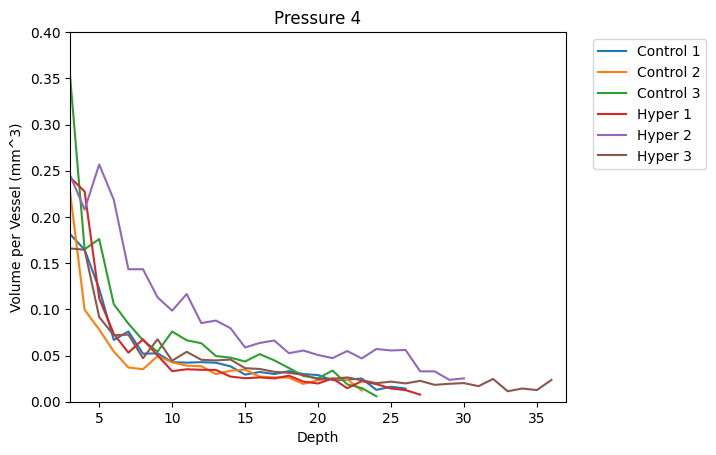

In [43]:
plt.plot(c1p4p,c1p4va,label='Control 1')
plt.plot(c2p4p,c2p4va,label='Control 2')
plt.plot(c3p4p,c3p4va,label='Control 3')
plt.plot(h1p4p,h1p4va,label='Hyper 1')
plt.plot(h2p4p,h2p4va,label='Hyper 2')
plt.plot(h3p4p,h3p4va,label='Hyper 3')
plt.ylabel('Volume per Vessel (mm^3)')
plt.xlabel('Depth')
plt.xlim(3,37)
plt.ylim(0,.4)
plt.title('Pressure 4')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

In [ ]:
plt.scatter(control3p4['LengthFromRoot'],control3p4['Volume'], marker='x',label='Control')
plt.scatter(hyper1p4['LengthFromRoot'],hyper1p4['Volume'], marker='.',label='Hyper')
plt.ylabel('Volume (mm^3)')
plt.xlabel('LengthFromRoot (mm)')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

In [ ]:
print('Control: ' + str(control3p4[control3p4['Volume']>.25e9]['Parent'].count()))
print('Hyper: ' + str(hyper1p4[hyper1p4['Volume']>.25e9]['Parent'].count()))

In [ ]:
meanc = control3p4['Volume'].mean()
stdc = control3p4['Volume'].std()
cvolumeFilter = control3p4[(control3p4['Volume'] >= meanc - 3 * stdc) & 
                        (control3p4['Volume'] <= meanc + 3 * stdc)]
cinternalVol = cvolumeFilter.dropna(subset='DV1R')
meanh = hyper1p4['Volume'].mean()
stdh = hyper1p4['Volume'].std()
hvolumeFilter = hyper1p4[(hyper1p4['Volume'] >= meanh - 3 * stdh) & 
                        (hyper1p4['Volume'] <= meanh + 3 * stdh)]
hinternalVol = hvolumeFilter.dropna(subset='DV1R')

a = 'Gamma'
b = 'Volume'
d = cinternalVol[a]
e = cinternalVol[b]
f = hinternalVol[a]
g = hinternalVol[b]

plt.scatter(d,e,c='b', marker='x',label='Control 3')
plt.scatter(f,g,c='r',marker='.',label='Hyper 1')
plt.ylabel(b)
plt.xlabel(a)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

# Volume Idea Pressure 1

In [33]:
print('Control 1: ' + str(int(control1p1['Volume'].sum())/(1000**3)))
print('Control 2: ' + str(int(control2p1['Volume'].sum())/(1000**3)))
#print('Control 3: ' + str(int(control3p1['Volume'].sum())/(1000**3)))
print('Hyper 1: ' + str(int(hyper1p1['Volume'].sum())/(1000**3)))
print('Hyper 2: ' + str(int(hyper2p1['Volume'].sum())/(1000**3)))
print('Hyper 3: ' + str(int(hyper3p1['Volume'].sum())/(1000**3)))
#print('Hyper trimmed: ' + str(int(hyper1p4[hyper1p4['Depth']<=26]['Volume'].sum())/(1000**3)))
#print('Difference: ' + str((int(hyper1p4['Volume'].sum())-int(control3p4['Volume'].sum()))/(1000**3)))
#print('Hyper percent increase: ' + str((int(hyper1p4['Volume'].sum())-int(control2p4['Volume'].sum()))/int(control2p4['Volume'].sum())*100))

Control 1: 86.998578102
Control 2: 100.801060437
Hyper 1: 95.197190621
Hyper 2: 107.677368384
Hyper 3: 97.948324404


In [34]:
c1p1vs = control1p1.groupby('Depth')['Volume'].sum()/(1000**3)
c1p1d = control1p1.groupby('Depth')['Depth'].count()
c1p1va = control1p1.groupby('Depth')['Volume'].mean()/(1000**3)
c1p1p = np.arange(0, len(c1p1d))
c2p1vs = control2p1.groupby('Depth')['Volume'].sum()/(1000**3)
c2p1d = control2p1.groupby('Depth')['Depth'].count()
c2p1va = control2p1.groupby('Depth')['Volume'].mean()/(1000**3)
c2p1p = np.arange(0, len(c2p1d))
#c3p1vs = control3p1.groupby('Depth')['Volume'].sum()/(1000**3)
#c3p1d = control3p1.groupby('Depth')['Depth'].count()
#c3p1va = control3p1.groupby('Depth')['Volume'].mean()/(1000**3)
#c3p1p = np.arange(0, len(c3p1d))
h1p1vs = hyper1p1.groupby('Depth')['Volume'].sum()/(1000**3)
h1p1d = hyper1p1.groupby('Depth')['Depth'].count()
h1p1va = hyper1p1.groupby('Depth')['Volume'].mean()/(1000**3)
h1p1p=np.arange(0,len(h1p1d))
h2p1vs = hyper2p1.groupby('Depth')['Volume'].sum()/(1000**3)
h2p1d = hyper2p1.groupby('Depth')['Depth'].count()
h2p1va = hyper2p1.groupby('Depth')['Volume'].mean()/(1000**3)
h2p1p=np.arange(0,len(h2p1d))
h3p1vs = hyper3p1.groupby('Depth')['Volume'].sum()/(1000**3)
h3p1d = hyper3p1.groupby('Depth')['Depth'].count()
h3p1va = hyper3p1.groupby('Depth')['Volume'].mean()/(1000**3)
h3p1p=np.arange(0,len(h3p1d))

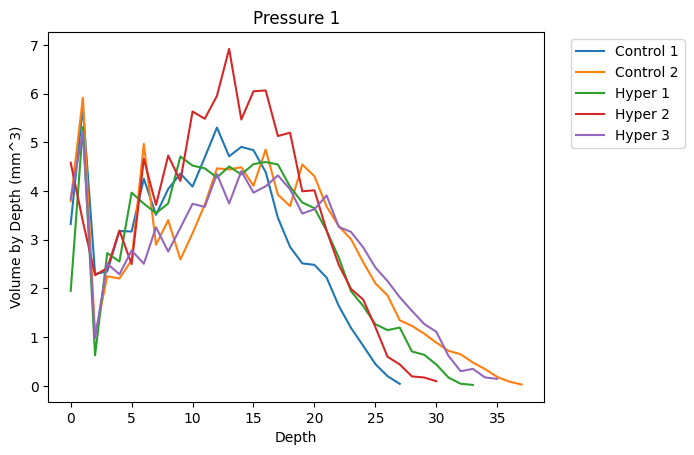

In [35]:
plt.plot(c1p1p,c1p1vs,label='Control 1')
plt.plot(c2p1p,c2p1vs,label='Control 2')
#plt.plot(c3p1p,c3p4vs,label='Control 3')
plt.plot(h1p1p,h1p1vs,label='Hyper 1')
plt.plot(h2p1p,h2p1vs,label='Hyper 2')
plt.plot(h3p1p,h3p1vs,label='Hyper 3')
plt.ylabel('Volume by Depth (mm^3)')
plt.xlabel('Depth')
plt.title('Pressure 1')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

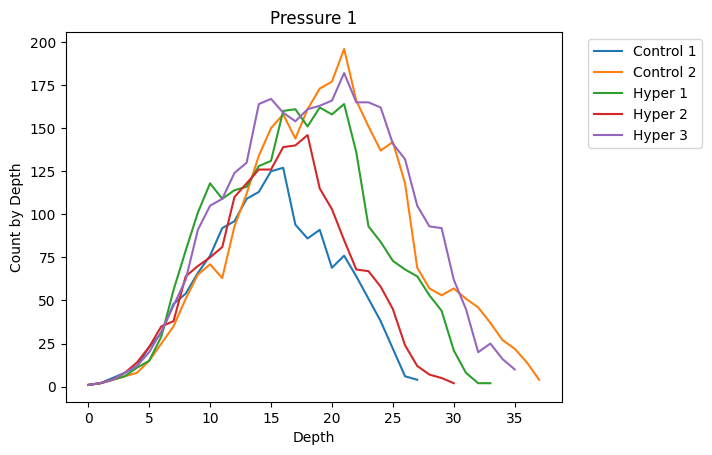

In [36]:
plt.plot(c1p1p,c1p1d,label='Control 1')
plt.plot(c2p1p,c2p1d,label='Control 2')
#plt.plot(c3p1p,c3p1d,label='Control 3')
plt.plot(h1p1p,h1p1d,label='Hyper 1')
plt.plot(h2p1p,h2p1d,label='Hyper 2')
plt.plot(h3p1p,h3p1d,label='Hyper 3')
plt.ylabel('Count by Depth')
plt.xlabel('Depth')
plt.title('Pressure 1')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

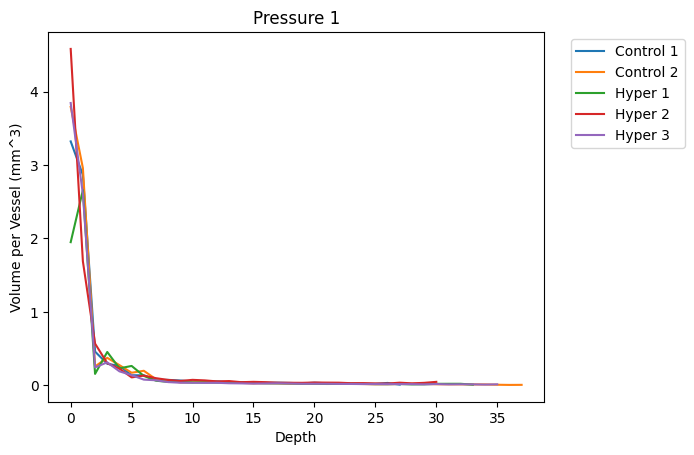

In [37]:
plt.plot(c1p1p,c1p1va,label='Control 1')
plt.plot(c2p1p,c2p1va,label='Control 2')
#plt.plot(c3p1p,c3p1va,label='Control 3')
plt.plot(h1p1p,h1p1va,label='Hyper 1')
plt.plot(h2p1p,h2p1va,label='Hyper 2')
plt.plot(h3p1p,h3p1va,label='Hyper 3')
plt.ylabel('Volume per Vessel (mm^3)')
plt.xlabel('Depth')
plt.title('Pressure 1')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

In [ ]:
plt.scatter(control3p4['LengthFromRoot'],control3p4['Volume'], marker='x',label='Control')
plt.scatter(hyper1p4['LengthFromRoot'],hyper1p4['Volume'], marker='.',label='Hyper')
plt.ylabel('Volume (mm^3)')
plt.xlabel('LengthFromRoot (mm)')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

# Splitting by Lobes

In [7]:
def lobeExtractor(name, vesID):
    data = dataExtractor(name)
    
    tree = defaultdict(list)
    for _,row in data.iterrows():
        parent = row['Parent']
        for daughter_col in ['Daughter1','Daughter2','Daughter3']:
            daughter = row[daughter_col]
            if pd.notna(daughter):
                tree[parent].append(daughter)

    visited = set()
    queue = deque([vesID])

    while queue:
        current = queue.popleft()
        if current not in visited:
            visited.add(current)
            queue.extend(tree.get(current,[]))
    
    downstream_df = data[data['Parent'].isin(visited)]
    return downstream_df.reset_index()

In [11]:
left_lobe = lobeExtractor('m3p4_060407',1033)
left_lobe.to_csv('all_left_lobe')

# Tortuosity

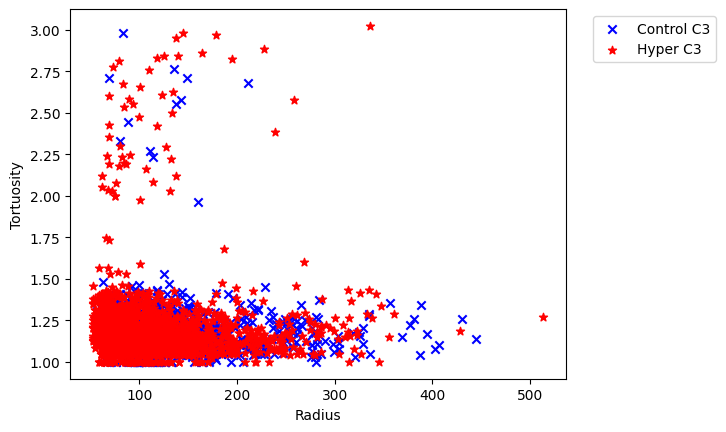

In [50]:
c3p4r = control3p4['Radius']
c3p4t = control3p4['Tortuosity']
h1p4r = hyper1p4['Radius']
h1p4t = hyper1p4['Tortuosity']
plt.scatter(c3p4r,c3p4t, c='b', marker='x', label='Control C3')
plt.scatter(h1p4r, h1p4t, c='r', marker='*', label='Hyper C3')
plt.ylabel('Tortuosity')
plt.xlabel('Radius')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

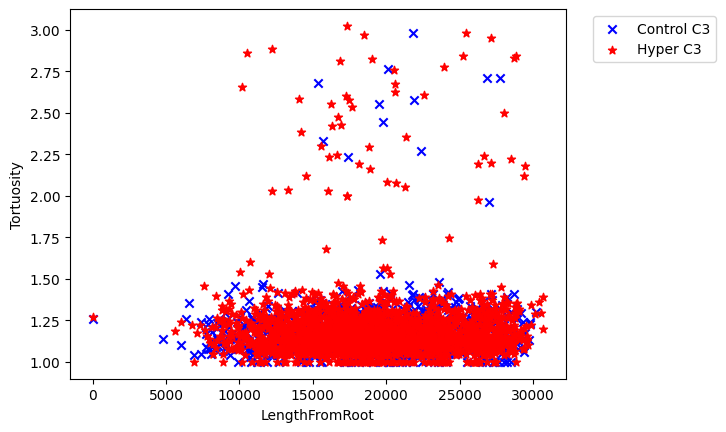

In [51]:
c3p4r = control3p4['LengthFromRoot']
c3p4t = control3p4['Tortuosity']
h1p4r = hyper1p4['LengthFromRoot']
h1p4t = hyper1p4['Tortuosity']
plt.scatter(c3p4r,c3p4t, c='b', marker='x', label='Control C3')
plt.scatter(h1p4r, h1p4t, c='r', marker='*', label='Hyper C3')
plt.ylabel('Tortuosity')
plt.xlabel('LengthFromRoot')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

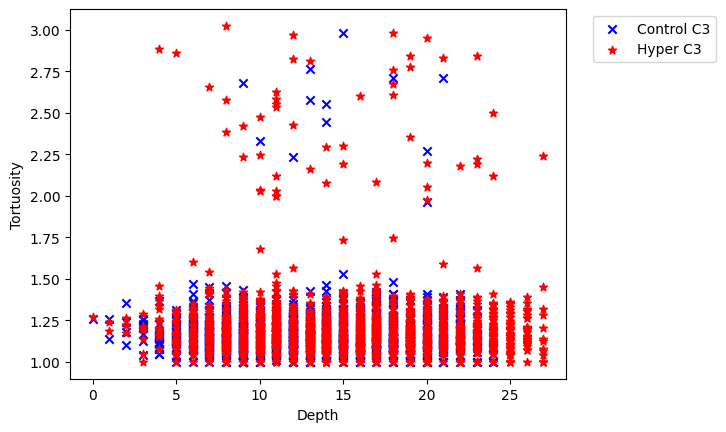

In [52]:
c3p4r = control3p4['Depth']
c3p4t = control3p4['Tortuosity']
h1p4r = hyper1p4['Depth']
h1p4t = hyper1p4['Tortuosity']
plt.scatter(c3p4r,c3p4t, c='b', marker='x', label='Control C3')
plt.scatter(h1p4r, h1p4t, c='r', marker='*', label='Hyper C3')
plt.ylabel('Tortuosity')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

In [59]:
c1p4t = control1p4.groupby('Depth')['Tortuosity'].mean()
c1p4d = control1p4.groupby('Depth')['Depth'].count()
c1p4p = np.arange(0, len(c1p4d))
c2p4t = control2p4.groupby('Depth')['Tortuosity'].mean()
c2p4d = control2p4.groupby('Depth')['Depth'].count()
c2p4p = np.arange(0, len(c2p4d))
c3p4t = control3p4.groupby('Depth')['Tortuosity'].mean()
c3p4d = control3p4.groupby('Depth')['Depth'].count()
c3p4p = np.arange(0, len(c3p4d))
h1p4t = hyper1p4.groupby('Depth')['Tortuosity'].mean()
h1p4d = hyper1p4.groupby('Depth')['Depth'].count()
h1p4p=np.arange(0,len(h1p4d))
h2p4t = hyper2p4.groupby('Depth')['Tortuosity'].mean()
h2p4d = hyper2p4.groupby('Depth')['Depth'].count()
h2p4p=np.arange(0,len(h2p4d))
h3p4t = hyper3p4.groupby('Depth')['Tortuosity'].mean()
h3p4d = hyper3p4.groupby('Depth')['Depth'].count()
h3p4p=np.arange(0,len(h3p4d))

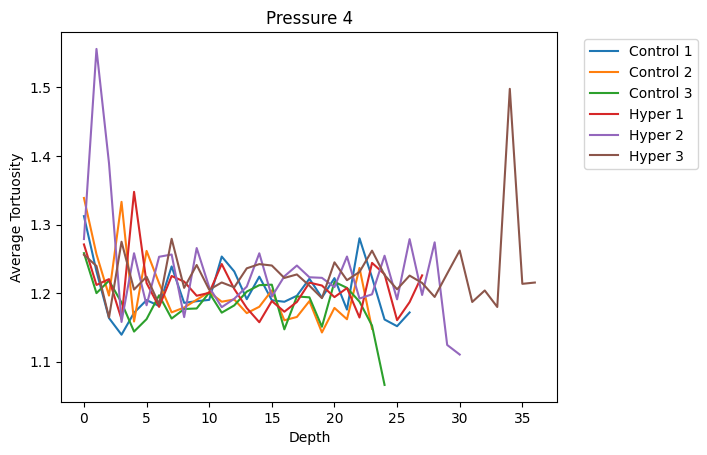

In [61]:
plt.plot(c1p4p,c1p4t,label='Control 1')
plt.plot(c2p4p,c2p4t,label='Control 2')
plt.plot(c3p4p,c3p4t,label='Control 3')
plt.plot(h1p4p,h1p4t,label='Hyper 1')
plt.plot(h2p4p,h2p4t,label='Hyper 2')
plt.plot(h3p4p,h3p4t,label='Hyper 3')
plt.ylabel('Average Tortuosity')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.title('Pressure 4')
plt.show()

In [62]:
c1p1t = control1p1.groupby('Depth')['Tortuosity'].mean()
c1p1d = control1p1.groupby('Depth')['Depth'].count()
c1p1p = np.arange(0, len(c1p1d))
c2p1t = control2p1.groupby('Depth')['Tortuosity'].mean()
c2p1d = control2p1.groupby('Depth')['Depth'].count()
c2p1p = np.arange(0, len(c2p1d))
#c3p1t = control3p1.groupby('Depth')['Tortuosity'].mean()
#c3p1d = control3p1.groupby('Depth')['Depth'].count()
#c3p1p = np.arange(0, len(c3p1d))
h1p1t = hyper1p1.groupby('Depth')['Tortuosity'].mean()
h1p1d = hyper1p1.groupby('Depth')['Depth'].count()
h1p1p=np.arange(0,len(h1p1d))
h2p1t = hyper2p1.groupby('Depth')['Tortuosity'].mean()
h2p1d = hyper2p1.groupby('Depth')['Depth'].count()
h2p1p=np.arange(0,len(h2p1d))
h3p1t = hyper3p1.groupby('Depth')['Tortuosity'].mean()
h3p1d = hyper3p1.groupby('Depth')['Depth'].count()
h3p1p=np.arange(0,len(h3p1d))

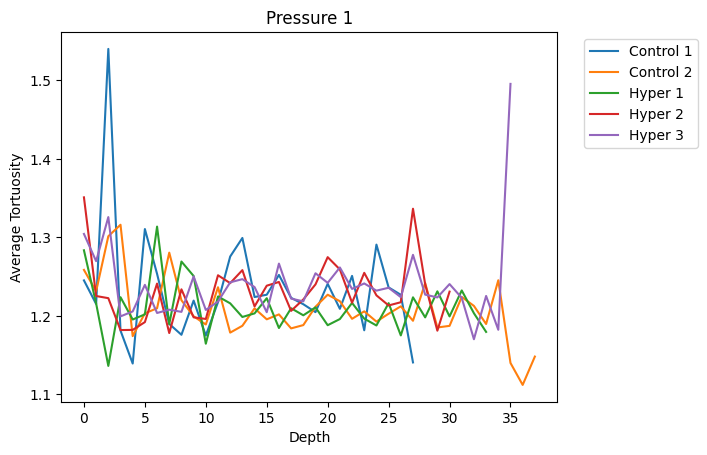

In [63]:
plt.plot(c1p1p,c1p1t,label='Control 1')
plt.plot(c2p1p,c2p1t,label='Control 2')
#plt.plot(c3p1p,c3p1t,label='Control 3')
plt.plot(h1p1p,h1p1t,label='Hyper 1')
plt.plot(h2p1p,h2p1t,label='Hyper 2')
plt.plot(h3p1p,h3p1t,label='Hyper 3')
plt.ylabel('Average Tortuosity')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.title('Pressure 1')
plt.show()

# Standardized by Volume

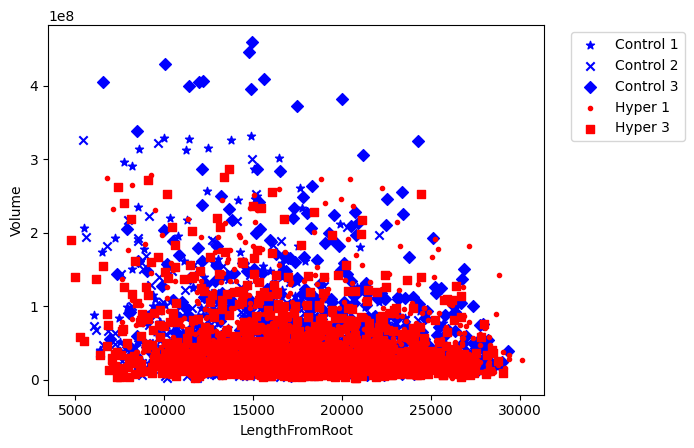

In [ ]:
def volumeStandardizer(data):
    mean = data['Volume'].mean()
    std = data['Volume'].std()
    volumeFilter = data[(data['Volume'] >= mean - 2 * std) & 
                            (data['Volume'] <= mean + 2 * std)]
    internalVol = volumeFilter.dropna(subset='DV1R')
    return internalVol

y = 'Volume'
x = 'LengthFromRoot'
control1p4vs = volumeStandardizer(control1p4)
c1p4x = control1p4vs[x]
c1p4y = control1p4vs[y]
control2p4vs = volumeStandardizer(control2p4)
c2p4x = control2p4vs[x]
c2p4y = control2p4vs[y]
control3p4vs = volumeStandardizer(control3p4)
c3p4x = control3p4vs[x]
c3p4y = control3p4vs[y]
hyper1p4vs = volumeStandardizer(hyper1p4)
h1p4x = hyper1p4vs[x]
h1p4y = hyper1p4vs[y]
hyper2p4vs = volumeStandardizer(hyper2p4)
h2p4x = hyper2p4vs[x]
h2p4y = hyper2p4vs[y]
hyper3p4vs = volumeStandardizer(hyper3p4)
h3p4x = hyper3p4vs[x]
h3p4y = hyper3p4vs[y]

plt.scatter(c1p4x,c1p4y,c='b', marker='*',label='Control 1')
plt.scatter(c2p4x,c2p4y,c='b', marker='x',label='Control 2')
plt.scatter(c3p4x,c3p4y,c='b', marker='D',label='Control 3')
plt.scatter(h1p4x,h1p4y,c='r',marker='.',label='Hyper 1')
#plt.scatter(h2p4x,h2p4y,c='r',marker='+',label='Hyper 2')
plt.scatter(h3p4x,h3p4y,c='r',marker=',',label='Hyper 3')
plt.ylabel(y)
plt.xlabel(x)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()